In [85]:
%%capture
!pip install -r requirement.txt

In [71]:
import psycopg2
from pyspark.sql import SparkSession
from pyspark.sql.functions import dayofweek
import json

import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [72]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("vis") \
    .config("spark.jars", "/home/jovyan/work/postgresql-42.2.23.jar") \
    .getOrCreate()

In [241]:
df = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://nyc_tripdata_db_1:5432/postgres") \
    .option("dbtable", "trips") \
    .option("user", "postgres") \
    .option("password", "postgres1234") \
    .option("driver", "org.postgresql.Driver") \
    .load()

In [242]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- vendor_name: string (nullable = true)
 |-- trip_pickup_datetime: timestamp (nullable = true)
 |-- trip_dropoff_datetime: timestamp (nullable = true)
 |-- trip_distance: decimal(5,2) (nullable = true)
 |-- start_lon: double (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- end_lon: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- trip_duration: decimal(10,0) (nullable = true)



In [243]:
df.count()

9998

### Data Cleaning
Delete rows when trip duration is negtive values.

In [244]:
df_negative = df.filter(df.trip_duration < 0)
df_negative.count()

195

In [245]:
df_negative.select(df.trip_pickup_datetime, df.trip_dropoff_datetime).show(10)

+--------------------+---------------------+
|trip_pickup_datetime|trip_dropoff_datetime|
+--------------------+---------------------+
| 2009-01-25 16:08:00|  2009-01-25 16:07:00|
| 2009-01-24 23:37:00|  2009-01-24 23:34:00|
| 2009-01-25 21:42:00|  2009-01-25 21:41:00|
| 2009-01-24 11:14:00|  2009-01-24 11:12:00|
| 2009-01-11 21:43:00|  2009-01-11 21:39:00|
| 2009-01-13 20:26:00|  2009-01-13 20:24:00|
| 2009-01-10 03:50:00|  2009-01-10 03:40:00|
| 2009-01-09 16:52:00|  2009-01-09 16:45:00|
| 2009-01-11 00:38:00|  2009-01-11 00:34:00|
| 2009-01-09 04:54:00|  2009-01-09 04:50:00|
+--------------------+---------------------+
only showing top 10 rows



In [246]:
df = df.filter(df.trip_duration >= 0)
df.count()

9803

### understanding our dataset by some visualization

#### trip duration:
let's see the distribution of the trip duration. to make the histogram more informatic, we plot the logarithm of the values.

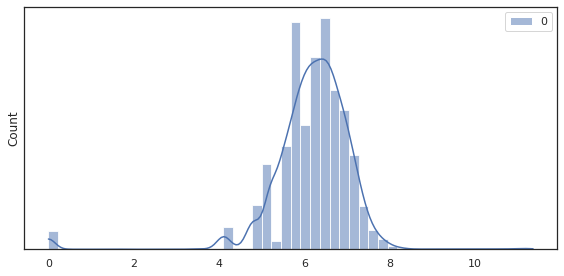

In [247]:
f, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.set(style="white")
sns.histplot(np.log(np.array(np.array(df.select('trip_duration').collect()).astype(int))+1),
             label = 'log(trip_duration)', 
             stat = 'count',
             bins = 50,
             kde=True)

plt.setp(ax, yticks=[])
plt.tight_layout()
plt.show()

#### Longitude and Latitude:
Let's plot the longitude and latitude of the start and end of our trips.

(2, 2)


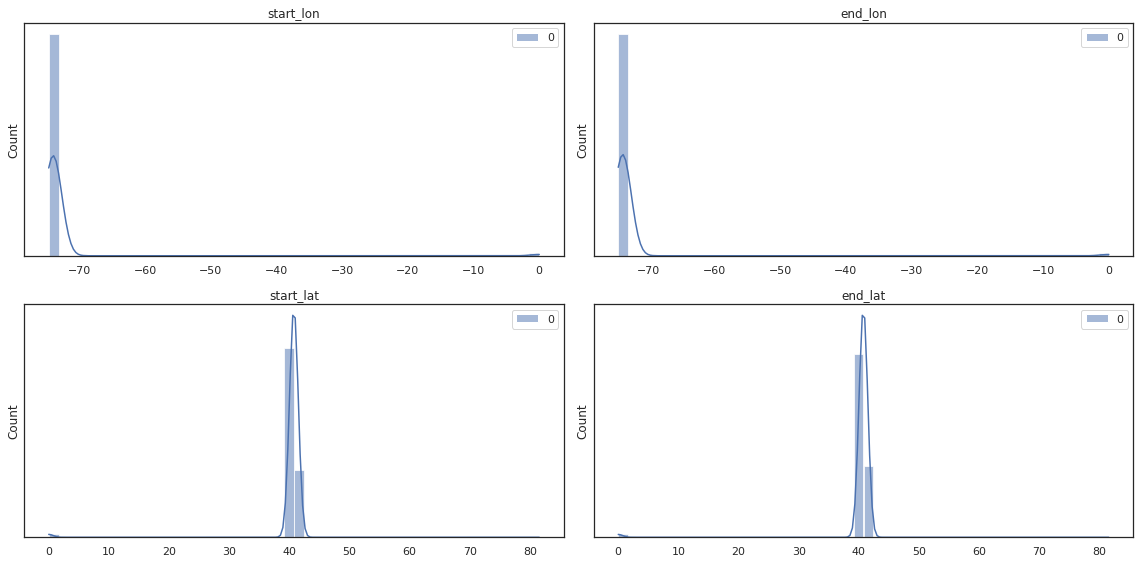

In [248]:
f, ax = plt.subplots(2, 2, figsize=(16, 8))
sns.set(style="white")
sns.histplot(np.array(df.select('start_lon').collect()),
             stat = 'count',
             bins = 50,
             kde=True,
             ax = ax[0,0]).set_title("start_lon")

sns.histplot(np.array(df.select('end_lon').collect()),
             stat = 'count',
             bins = 50,
             kde=True,
             ax = ax[0,1]).set_title("end_lon")

sns.histplot(np.array(df.select('start_lat').collect()),
             stat = 'count',
             bins = 50,
             kde=True,
             ax = ax[1,0]).set_title("start_lat")

sns.histplot(np.array(df.select('end_lat').collect()),
             stat = 'count',
             bins = 50,
             kde=True,
             ax = ax[1,1]).set_title("end_lat")


plt.setp(ax, yticks=[])
plt.tight_layout()
plt.show()

Remove rides to and from far away areas.

In [249]:
lons = [-74.03, -73.77]
lats = [40.63, 40.85]

In [250]:
# tmp = df.filter( (df.start_lon >= -65) | (df.end_lon >= -65) | (df.start_lat > 45) | (df.end_lat > 45))
# print(f"We are going to drop {tmp.count()} sampels.")

In [251]:
df = df.filter( (df.start_lon.between(lons[0], lons[1])) & 
               (df.end_lon.between(lons[0], lons[1])) & 
               (df.start_lat.between(lats[0], lats[1])) & 
               (df.end_lat.between(lats[0], lats[1]))) 
print(f"We keep {df.count()}")

We keep 9556


(2, 2)


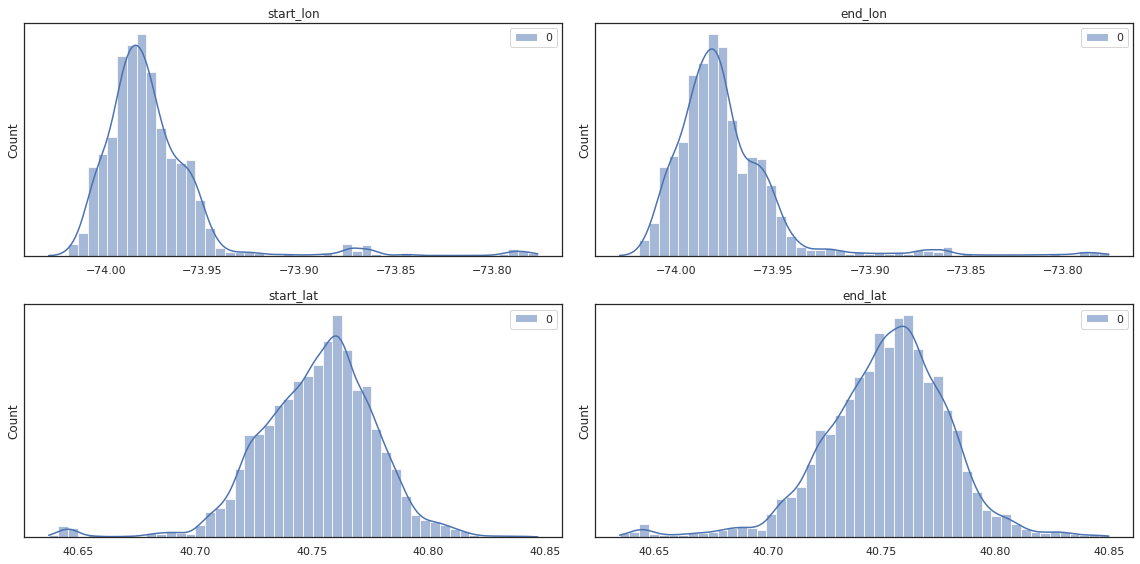

In [252]:
f, ax = plt.subplots(2, 2, figsize=(16, 8))
sns.set(style="white")
sns.histplot(np.array(df.select('start_lon').collect()),
             stat = 'count',
             bins = 50,
             kde=True,
             ax = ax[0,0]).set_title("start_lon")

sns.histplot(np.array(df.select('end_lon').collect()),
             stat = 'count',
             bins = 50,
             kde=True,
             ax = ax[0,1]).set_title("end_lon")

sns.histplot(np.array(df.select('start_lat').collect()),
             stat = 'count',
             bins = 50,
             kde=True,
             ax = ax[1,0]).set_title("start_lat")

sns.histplot(np.array(df.select('end_lat').collect()),
             label = 'end_lat', 
             stat = 'count',
             bins = 50,
             kde=True,
             ax = ax[1,1]).set_title("end_lat")


plt.setp(ax, yticks=[])
plt.tight_layout()
plt.show()

### add Day column

In [255]:
df = df.withColumn('day', dayofweek('trip_pickup_datetime'))
df.select('day').show(5)

+---+
|day|
+---+
|  1|
|  1|
|  7|
|  5|
|  7|
+---+
only showing top 5 rows



In [256]:
wdays_avg_duration = tmp.groupBy("day")\
                        .mean('trip_duration') \
                        .withColumnRenamed("avg(trip_duration)", "avg") \
                        .orderBy('day')

In [257]:
wdays_avg_duration = np.array(wdays_avg_duration.collect()).astype(float)
wdays_avg_duration[:4]

array([[  1.    , 620.8353],
       [  2.    , 660.6112],
       [  3.    , 714.2237],
       [  4.    , 668.7952]])

<AxesSubplot:>

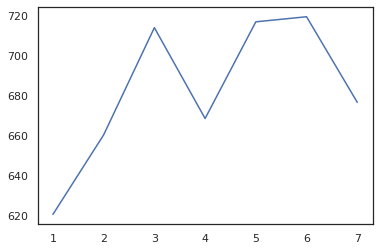

In [258]:
sns.lineplot(x = wdays_avg_duration[:,0], y=wdays_avg_duration[:, 1])

In [259]:
c = df.filter(df.trip_duration > 4000).count()
print(f"we have {c} trips with duration more than 4000 seconds. Let's drop them!")
df = df.filter(df.trip_duration <= 4000)

we have 14 trips with duration more than 5000 seconds. Let's drop them!


In [260]:
df_pandas = df.toPandas()

In [261]:
df_pandas.head()

,id,vendor_name,trip_pickup_datetime,trip_dropoff_datetime,trip_distance,start_lon,start_lat,end_lon,end_lat,trip_duration,day
0,1,VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,2.63,-73.991957,40.721567,-73.993803,40.695922,600,1
1,2,VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,4.55,-73.982102,40.736290,-73.955850,40.768030,420,1
2,3,VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,10.35,-74.002587,40.739748,-73.869983,40.770225,840,7
3,4,DDS,2009-01-01 20:52:58,2009-01-01 21:14:00,5.00,-73.974267,40.790955,-73.996558,40.731849,1262,5
4,5,DDS,2009-01-24 16:18:23,2009-01-24 16:24:56,0.40,-74.001580,40.719382,-74.008378,40.720350,393,7


In [262]:
df_pandas = df_pandas.astype({"trip_duration": int})

<AxesSubplot:xlabel='day', ylabel='trip_duration'>

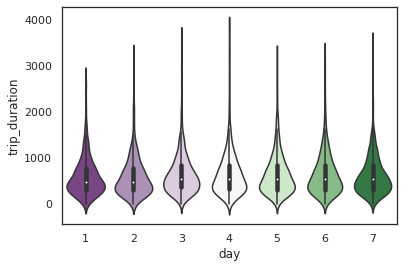

In [263]:
sns.violinplot(x="day", y="trip_duration", data=df_pandas, palette="PRGn")

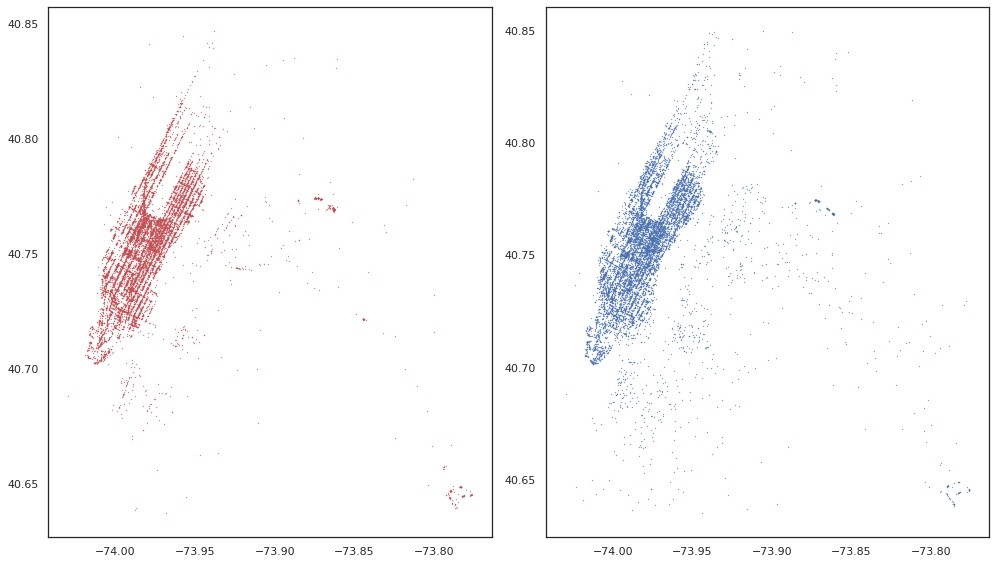

In [281]:
f, axes = plt.subplots(1, 2, figsize=(14, 8))
start_longitude = [x[0] for x in list(df.select(df.start_lon).collect())] 
srart_latitude  = [x[0] for x in list(df.select(df.start_lat).collect())]
end_longitude   = [x[0] for x in list(df.select(df.end_lon).collect())] 
end_latitude    = [x[0] for x in list(df.select(df.end_lat).collect())]
axes[0].plot(start_longitude,srart_latitude,'.', alpha = 1, markersize = 0.6, c= 'r')
axes[1].plot(end_longitude,end_latitude,'.', alpha = 1, markersize = 0.6, c= 'b')
plt.tight_layout()
plt.show()